<a href="https://colab.research.google.com/github/mc-ivan/mod8-kmeans/blob/main/notebook/Practica4_KMeans_IvanMamani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 4: K-Means
**Maestria en Ingenieria Matematica**

***MOD8: Modelaje Mediante IA en Economia***

**Participante:** Ivan Mamani Condori

---

Agrupar pacientes según características de salud utilizando K-Means

In [78]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

In [79]:
# Instalar e importar libreria para obtener el k-optimo automaticamente
!pip install kneed
from kneed import KneeLocator

In [80]:
# Cargar y explorar el dataset
url = "https://raw.githubusercontent.com/mc-ivan/mod8-kmeans/main/dataset/health_patients.csv"
df = pd.read_csv(url)
print("Vista inicial del dataset:")
display(df.head())

Vista inicial del dataset:


,age,bmi,cholesterol,blood_pressure,physical_activity,smoking_years,glucose,risk_score
0,57.5,30.8,194.5,109.2,4,27,74.5,58.62
1,47.9,24.9,241.2,122.7,6,1,105.2,59.98
2,59.7,27.4,180.6,111.8,2,24,136.6,56.80
3,72.8,25.2,176.0,115.9,0,5,111.2,54.03
4,46.5,25.3,185.5,145.1,2,10,124.0,58.61


In [81]:
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                800 non-null    float64
 1   bmi                800 non-null    float64
 2   cholesterol        800 non-null    float64
 3   blood_pressure     800 non-null    float64
 4   physical_activity  800 non-null    int64  
 5   smoking_years      800 non-null    int64  
 6   glucose            800 non-null    float64
 7   risk_score         800 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 50.1 KB


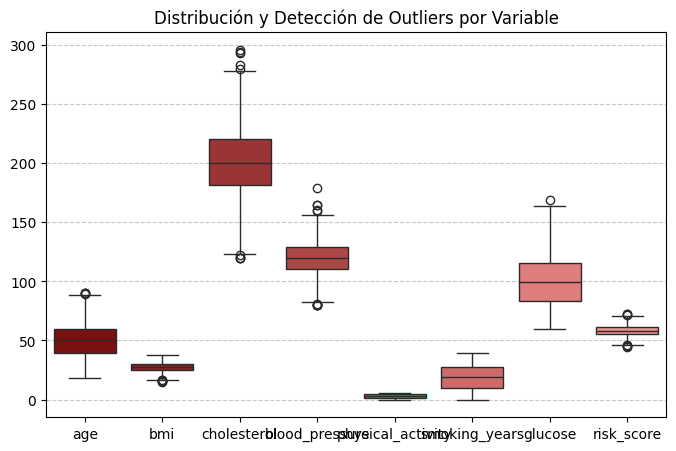

In [82]:
# Análisis Exploratorio (EDA rápido)
plt.figure(figsize=(8,5))
teal_palette = sns.color_palette("blend:#8B0000,#FF7F7F", n_colors=len(df.columns))
sns.boxplot(data=df, palette=teal_palette)
plt.title("Distribución y Detección de Outliers por Variable", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

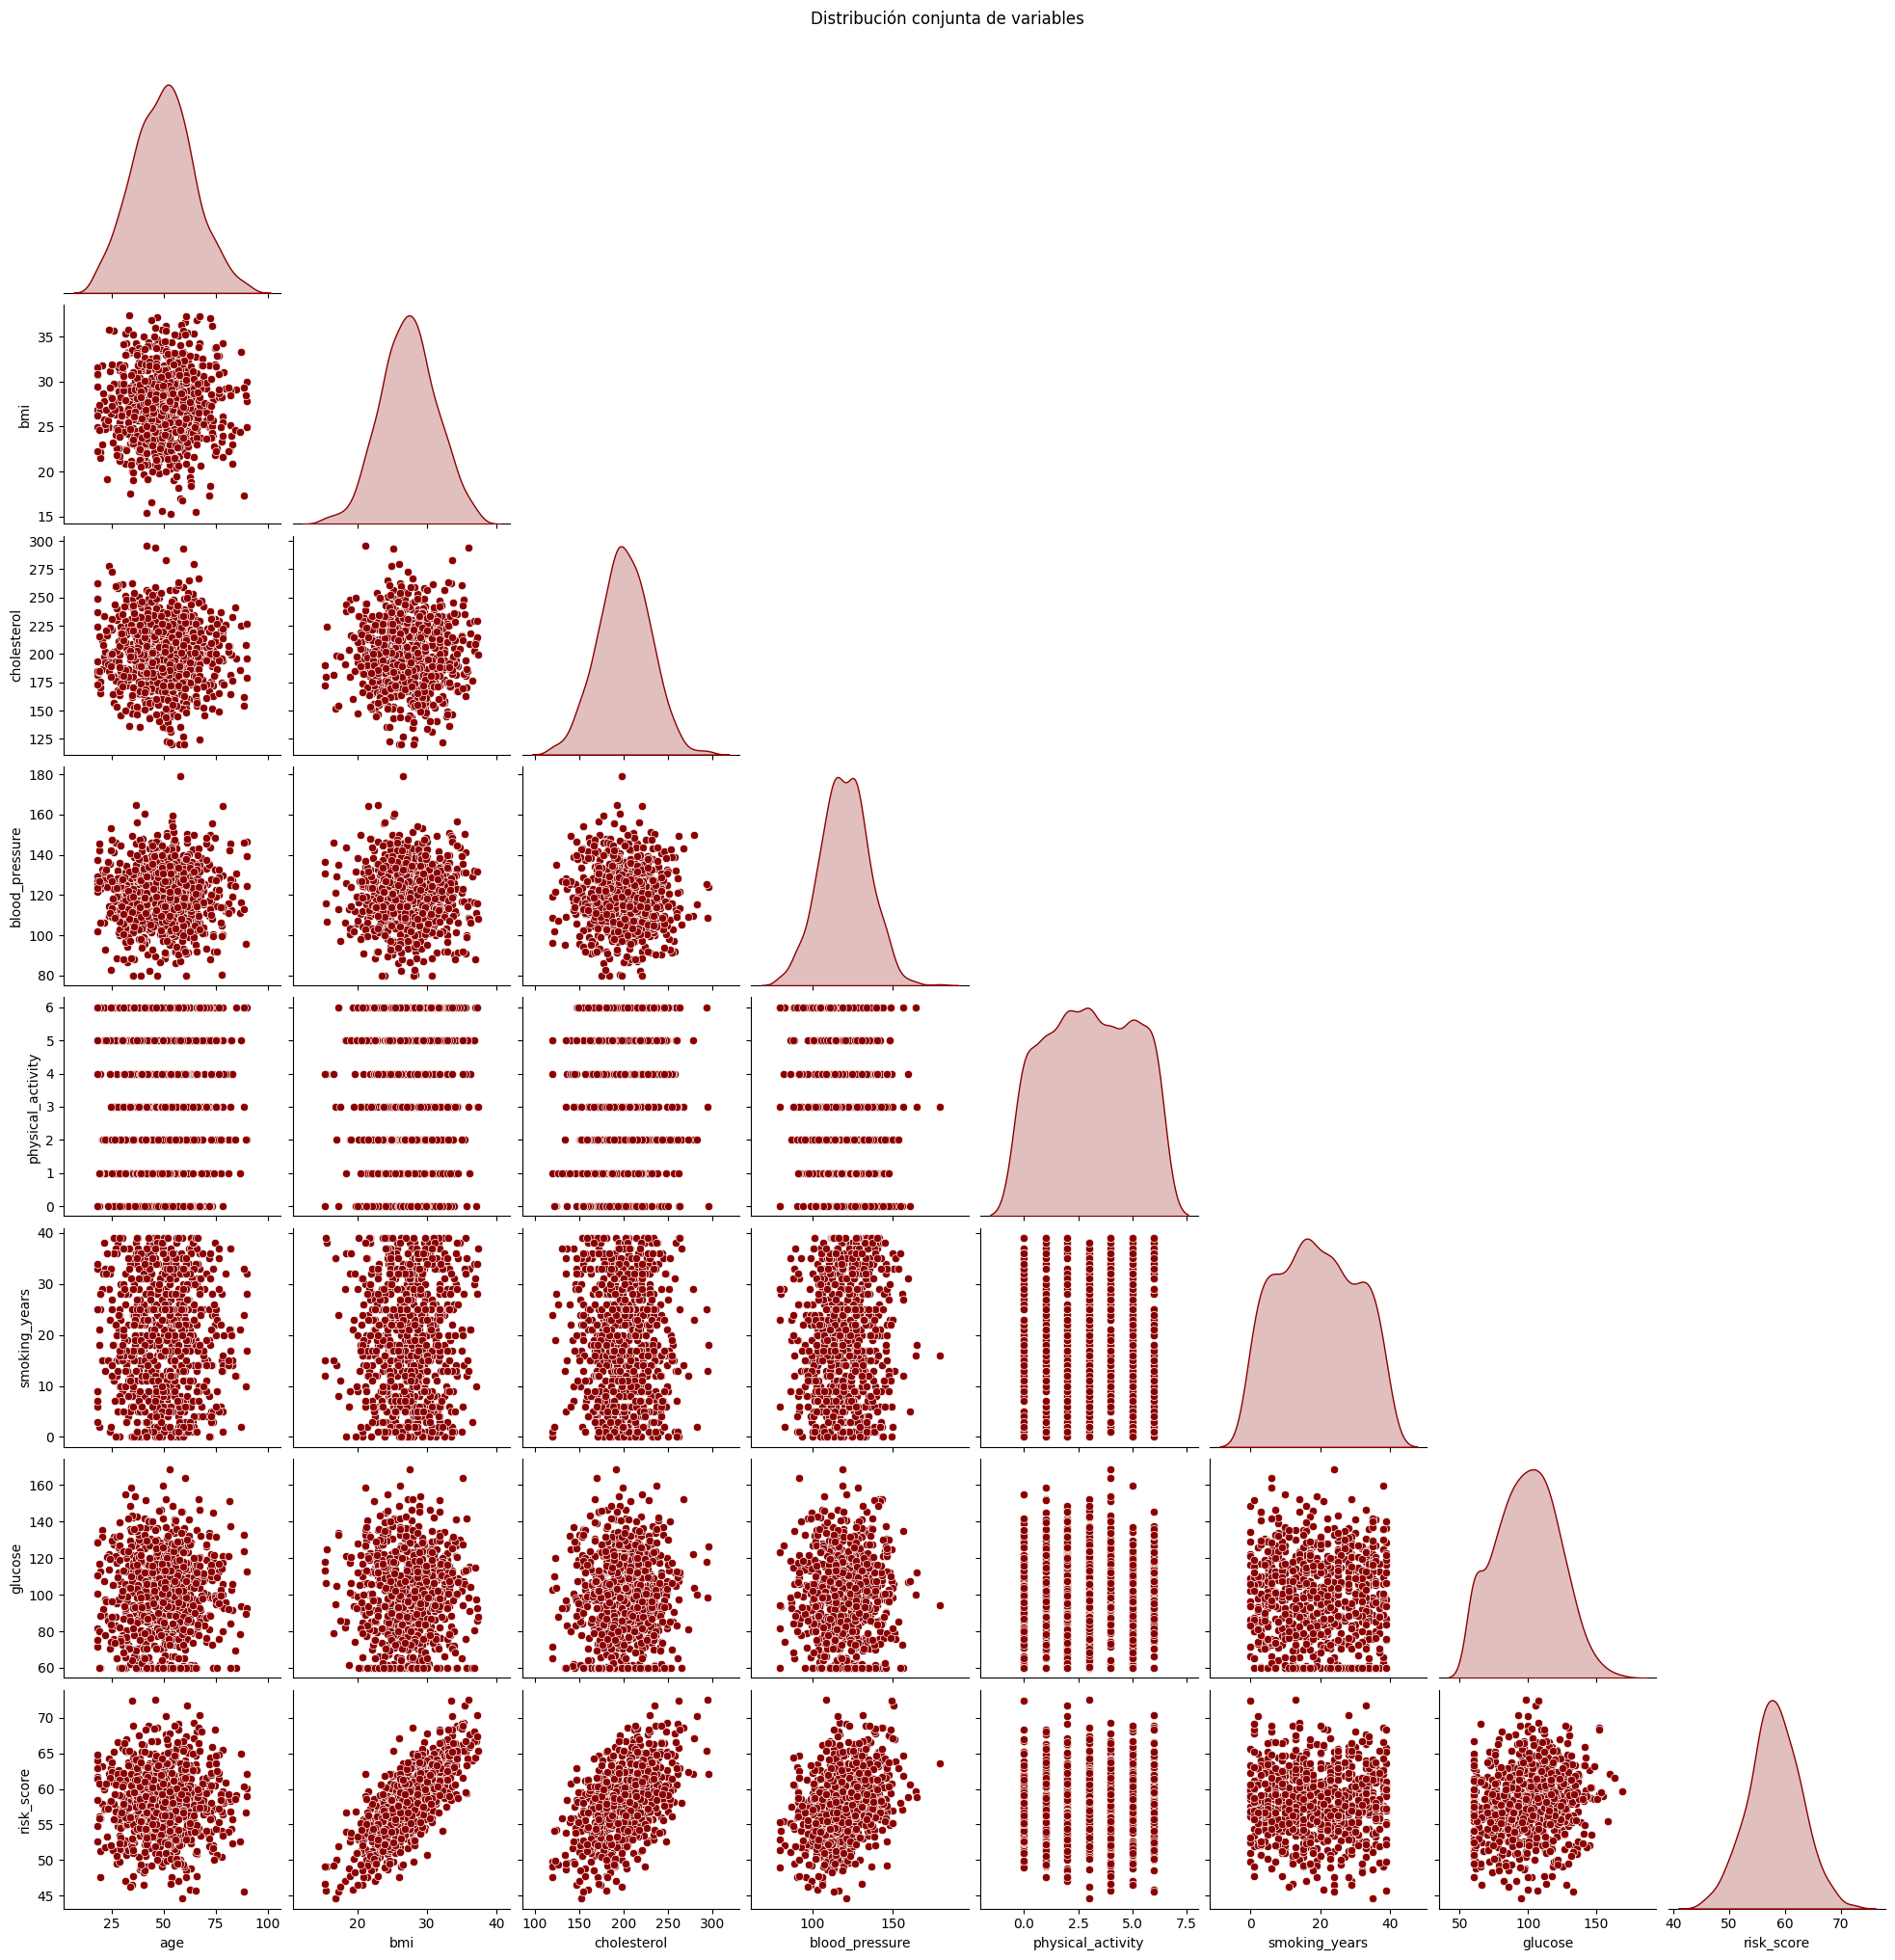

In [83]:
# Visualización multivariable (Pairplot)
# El gráfico de pares permite observar la distribución individual de cada variable
# y las relaciones entre pares de variables numéricas.
# Es útil para detectar correlaciones, patrones y posibles outliers.
sns.pairplot(df, diag_kind='kde', corner=True,
             plot_kws={'color': '#8B0000'},  # tono teal
             diag_kws={'color': '#8B0000'})
plt.suptitle("Distribución conjunta de variables", y=1.02)
plt.show()

In [84]:
# Detectar y eliminar outliers
# Copia del dataframe original
df_clean = df.copy()

# Filtrar outliers por cada columna numérica
for col in df_clean.select_dtypes(include=[np.number]).columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Filas originales: {df.shape[0]}, Filas sin outliers: {df_clean.shape[0]}")

Filas originales: 800, Filas sin outliers: 763


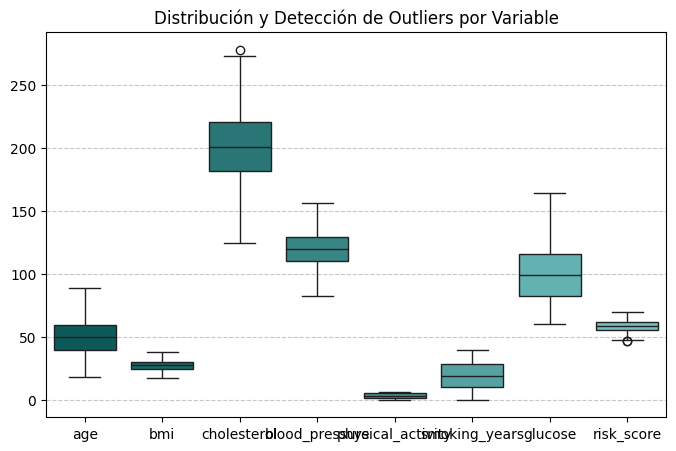

In [85]:
# Análisis Exploratorio (EDA) despues de la limpieza de outliers
plt.figure(figsize=(8,5))
teal_palette = sns.color_palette("blend:#006666,#66CCCC", n_colors=len(df_clean.columns))
sns.boxplot(data=df_clean, palette=teal_palette)
plt.title("Distribución y Detección de Outliers por Variable", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

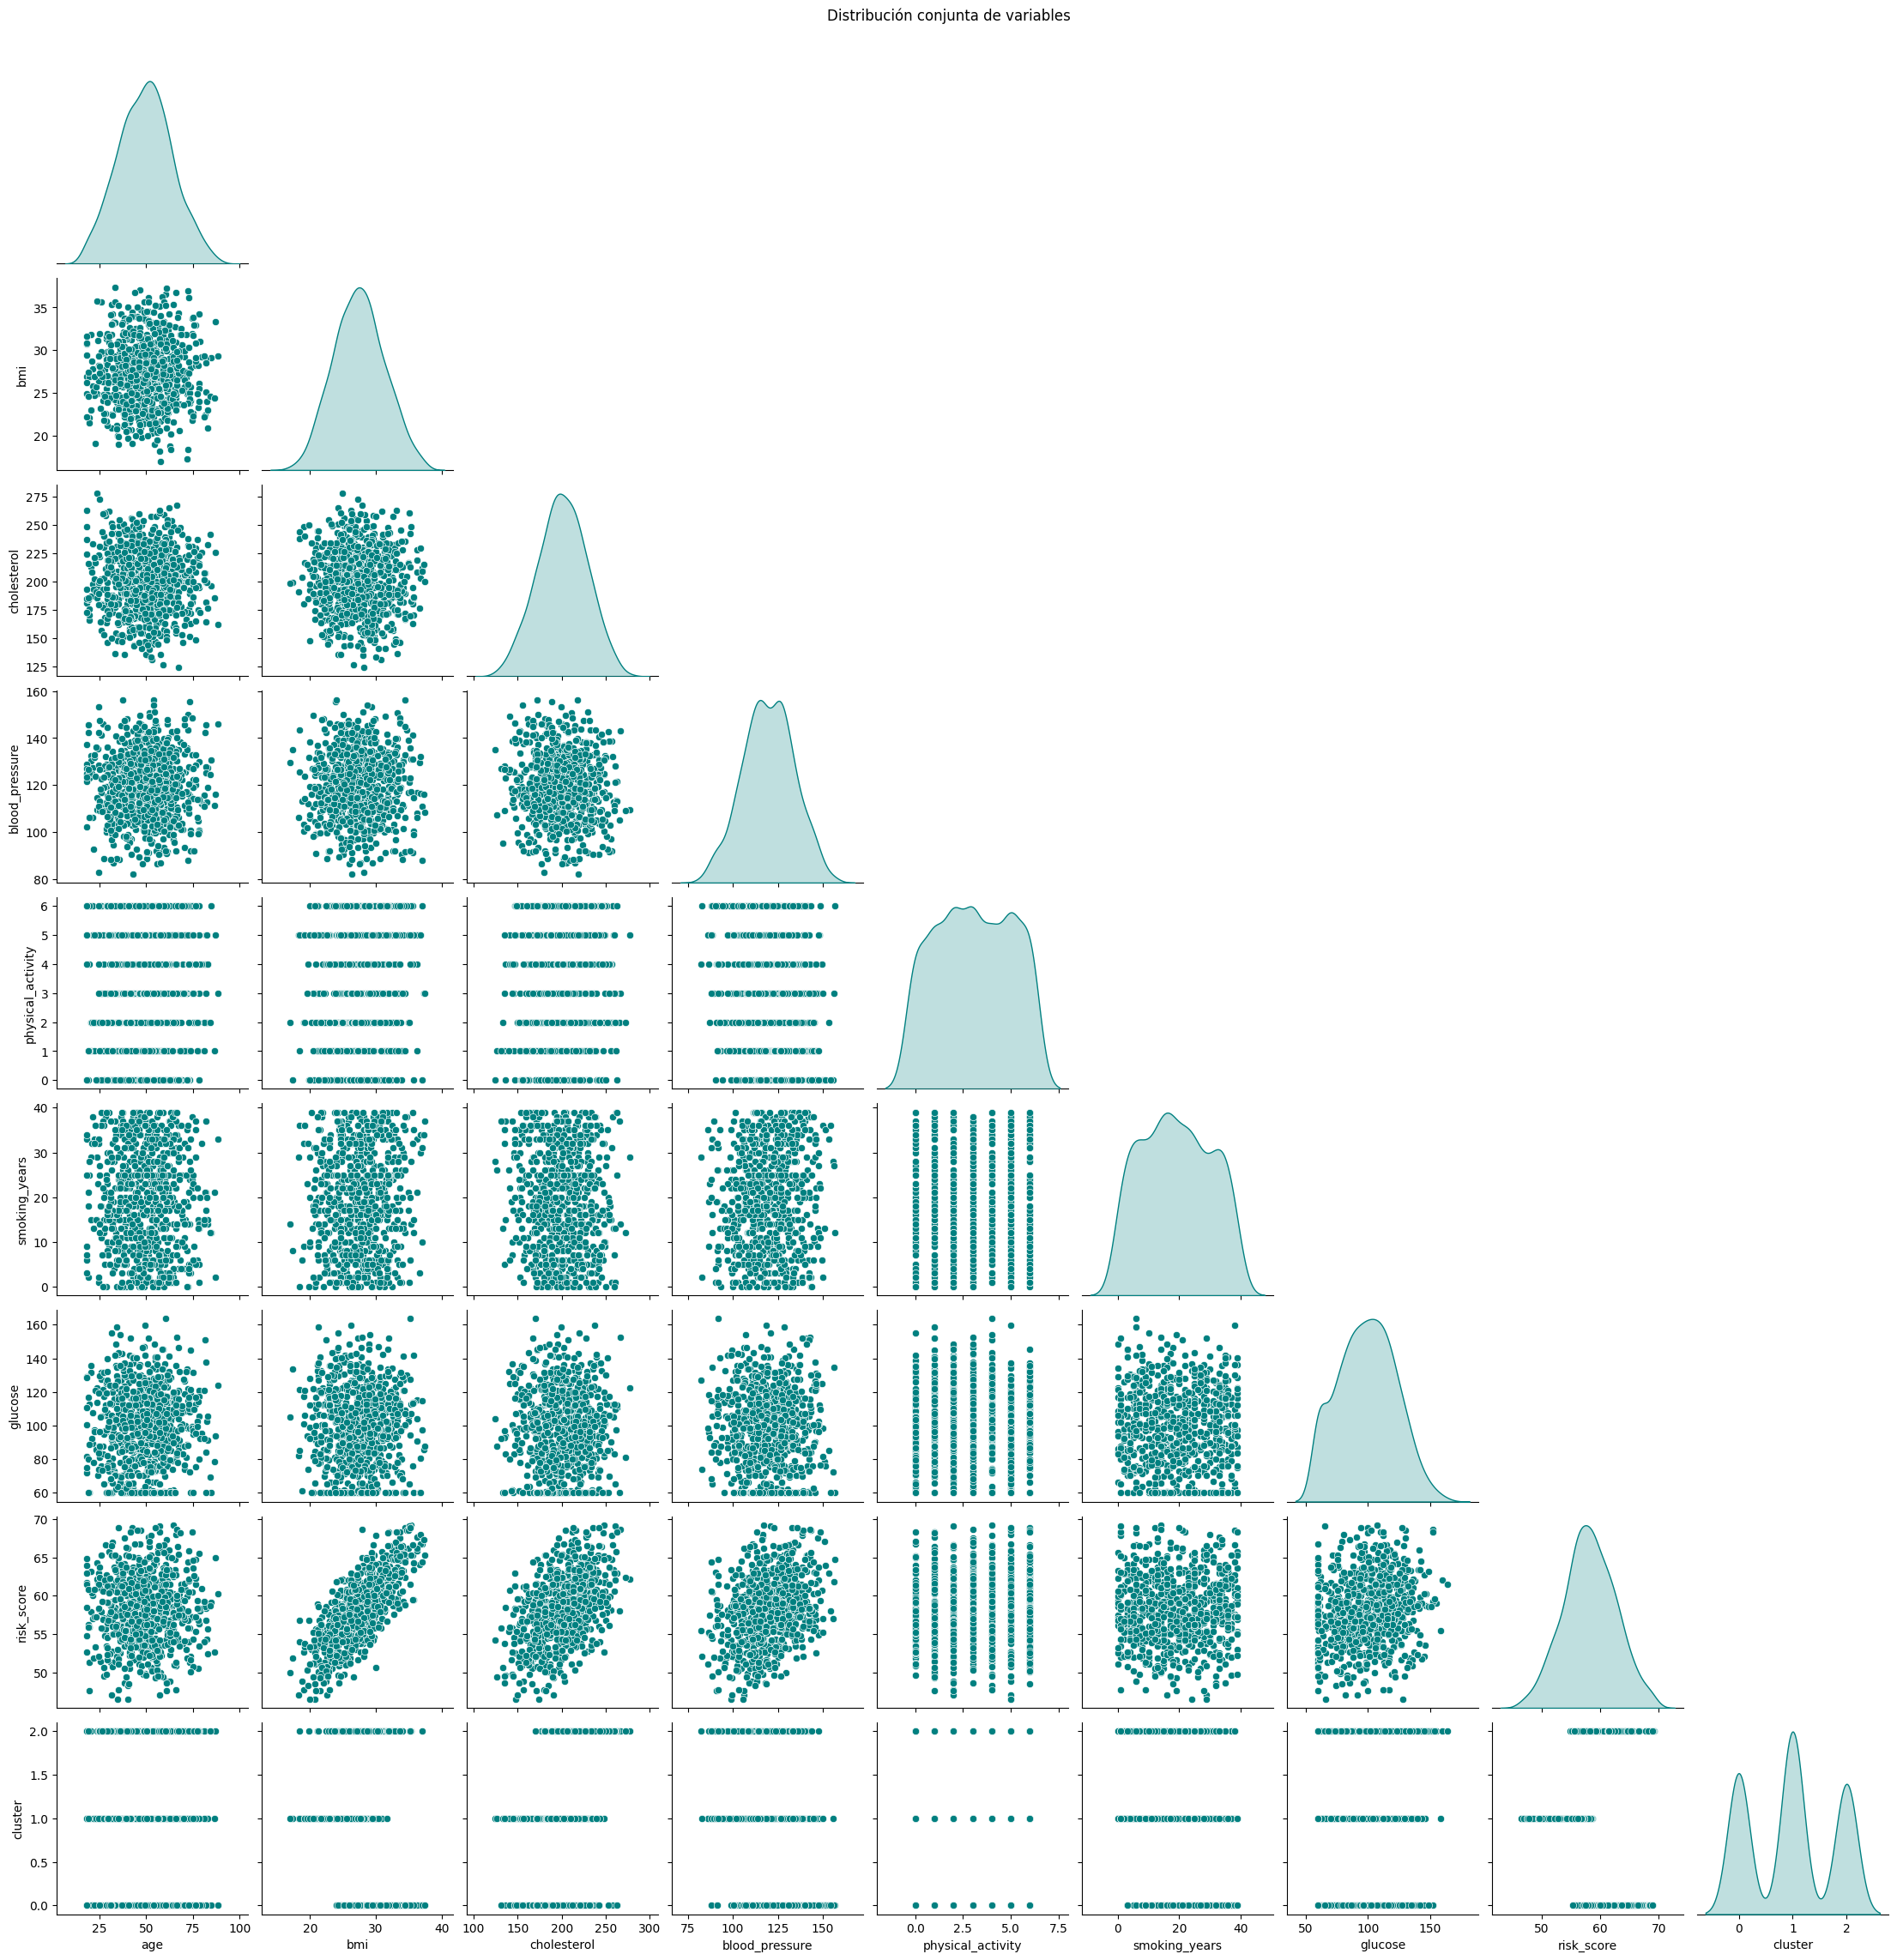

In [97]:
# Visualización multivariable (Pairplot) despues de la limpieza de outliers
sns.pairplot(df_clean, diag_kind='kde', corner=True,
             plot_kws={'color': '#008080'},  # tono teal
             diag_kws={'color': '#008080'})
plt.suptitle("Distribución conjunta de variables", y=1.02)
plt.show()

In [87]:
# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print("\nMatriz escalada (primeras 5 filas):")
print(X_scaled[:5])


Matriz escalada (primeras 5 filas):
[[ 0.55820772  0.8695592  -0.21905232 -0.74959613  0.47861058  0.71044155
  -1.07571628  0.09371615]
 [-0.11420827 -0.66535616  1.46712055  0.20888233  1.50009275 -1.61142658
   0.26897786  0.40233019]
 [ 0.71230306 -0.0149683  -0.72093247 -0.56500028 -0.54287158  0.44253369
   1.64433278 -0.31928205]
 [ 1.62987071 -0.58730962 -0.8870223  -0.27390682 -1.56435375 -1.25421609
   0.53178454 -0.94785624]
 [-0.21226894 -0.5612941  -0.54401069  1.7992466  -0.54287158 -0.80770299
   1.09243877  0.09144692]]


In [88]:
# Determinar número óptimo de clusters (Método del Codo)
sse = []
K_RANGE = range(1, 10)
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)


In [89]:
# Detectar el codo automáticamente
kl = KneeLocator(K_RANGE, sse, curve="convex", direction="decreasing")
k_optimo = kl.elbow
print(f"k óptimo detectado automáticamente: {k_optimo}")

k óptimo detectado automáticamente: 3


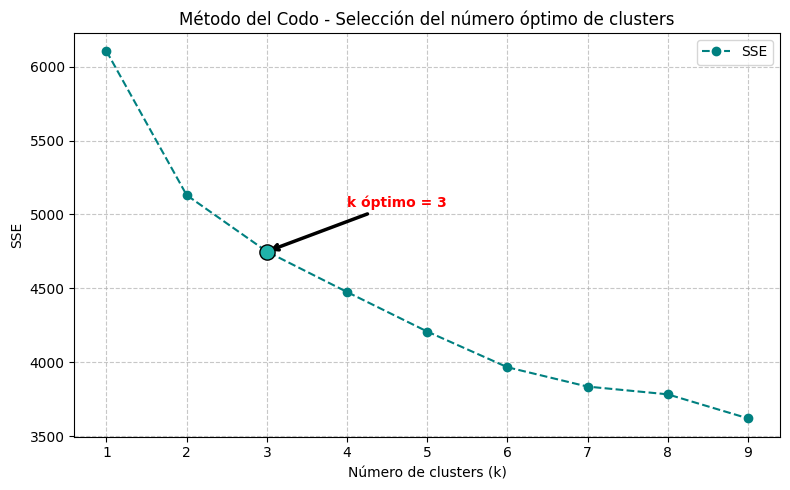

In [90]:
# Gráfica del método del codo
plt.figure(figsize=(8,5))
plt.plot(K_RANGE, sse, marker='o', linestyle='--', color='#008080', label='SSE')

# Marcar el codo con un punto y flecha
plt.scatter(k_optimo, sse[k_optimo-1], color='#20B2AA', s=120, edgecolors='black', zorder=5)
plt.annotate(
    f'k óptimo = {k_optimo}',
    xy=(k_optimo, sse[k_optimo-1]),           # punto del codo
    xytext=(k_optimo + 1, sse[k_optimo-1] + 300),  # posición del texto
    arrowprops=dict(facecolor='red', arrowstyle='->', lw=2.5),
    fontsize=10,
    color='red',
    fontweight='bold'
)

# Estética
plt.xlabel('Número de clusters (k)')
plt.ylabel('SSE')
plt.title('Método del Codo - Selección del número óptimo de clusters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# Entrenamiento de K-Means
K = k_optimo  # definido tras observar el codo
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=np.int64(3), random_state=42)

In [92]:
# Asignar etiquetas a cada paciente
df_clean['cluster'] = kmeans.labels_

In [93]:
# Evaluación del modelo
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.1137


In [94]:
# Interpretación de los clusters
summary = df_clean.groupby('cluster').agg({
    'age': 'mean',
    'bmi': 'mean',
    'cholesterol': 'mean',
    'blood_pressure': 'mean',
    'physical_activity': 'mean',
    'smoking_years': 'mean',
    'glucose': 'mean',
    'risk_score': ['mean', 'count']
}).round(2)

print("\nResumen de los clusters:")
display(summary)


Resumen de los clusters:


age    bmi cholesterol blood_pressure physical_activity  \
          mean   mean        mean           mean              mean   
cluster                                                              
0        50.46  30.68      197.46         126.95              3.43   
1        49.00  24.68      186.60         117.38              2.88   
2        49.27  27.86      223.51         115.31              2.93   

        smoking_years glucose risk_score        
                 mean    mean       mean count  
cluster                                         
0               26.55   98.69      61.59   237  
1               17.96   93.51      54.10   307  
2               12.44  107.24      60.31   219

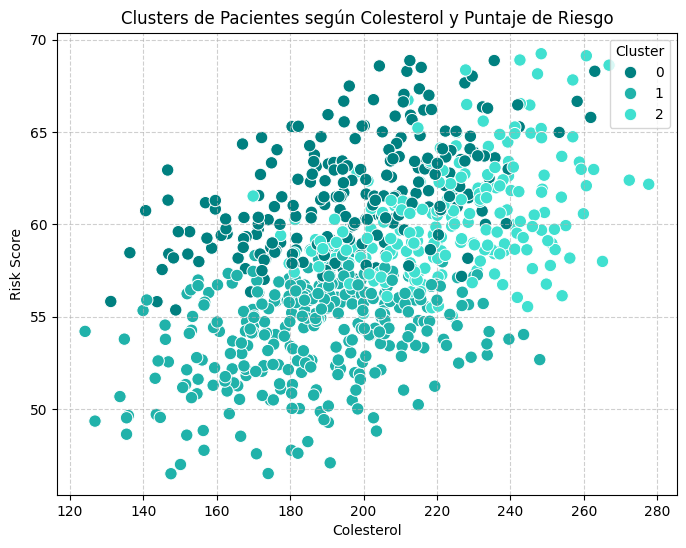

In [95]:
# Visualización de los clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='cholesterol',
    y='risk_score',
    hue='cluster',
    data=df_clean,
    palette=['#008080', '#20B2AA', '#40E0D0'],
    s=80,
    edgecolor='white'
)
plt.title("Clusters de Pacientes según Colesterol y Puntaje de Riesgo")
plt.xlabel("Colesterol")
plt.ylabel("Risk Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster')
plt.show()

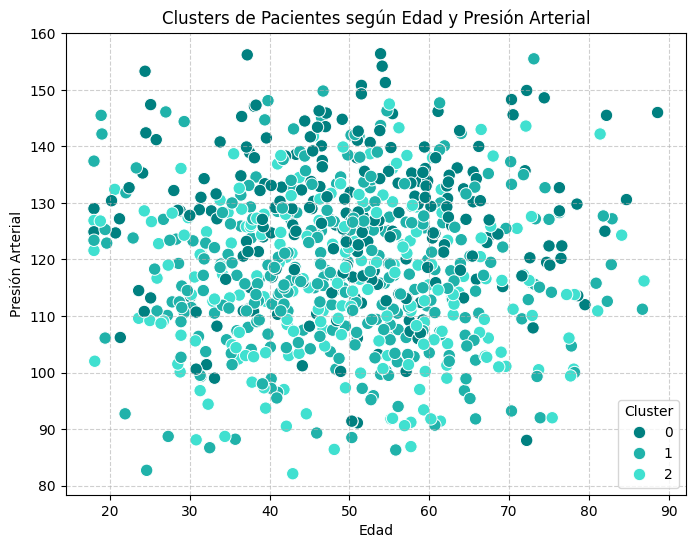

In [96]:
# Visualización adicional (Edad vs Presión)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='age',
    y='blood_pressure',
    hue='cluster',
    data=df_clean,
    palette=['#008080', '#20B2AA', '#40E0D0'],
    s=80,
    edgecolor='white'
)
plt.title("Clusters de Pacientes según Edad y Presión Arterial")
plt.xlabel("Edad")
plt.ylabel("Presión Arterial")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster')
plt.show()